In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\train"
val_path = r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\valid"
test_path = r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\test"

In [3]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


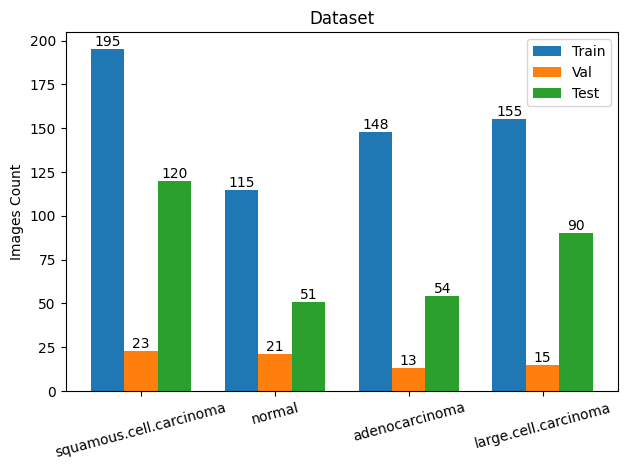

In [4]:
# Labels for each classs
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Labels location and bars widht 
x = np.arange(len(labels))  
width = 0.25  

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [6]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [7]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

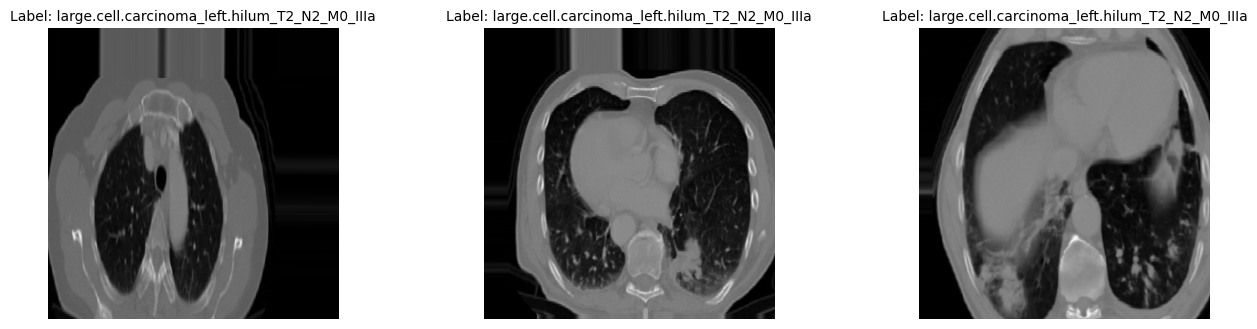

In [8]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))  
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

In [9]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(350,350,3)
)

In [10]:
NUM_CLASSES = 4


# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the 
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())

# A Dropout layer is added with a dropout rate of 25%. Dropout is used to prevent overfitting 
# by randomly disconnecting some neurons during training.
vgg_model.add(layers.Dropout(0.25))

# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function. 
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# The first layer of the model (base_model) is frozen, so the weights of this layer 
# will not be updated during training.
vgg_model.layers[0].trainable = False

# The model is compiled with the 'categorical_crossentropy' loss function,
#' adam' optimizer, and the accuracy metric. This prepares the model for training.
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];





In [12]:
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 2, #32
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4097 - loss: 2.6878
Epoch 1: val_accuracy improved from -inf to 0.54286, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.4102 - loss: 2.6833 - val_accuracy: 0.5429 - val_loss: 3.0631
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - accuracy: 0.8000 - loss: 1.2740
Epoch 2: val_accuracy improved from 0.54286 to 1.00000, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8000 - loss: 0.6422 - val_accuracy: 1.0000 - val_loss: 0.0043


In [13]:
# Train the VGG model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch=train_data.samples // train_data.batch_size, 
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data, 
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back 
)

# Evaluate the trained model
accuracy_vgg = vgg.history['val_accuracy'][-1]  # Assuming you're interested in the last epoch accuracy
loss_vgg = vgg.history['val_loss'][-1]  # Assuming you're interested in the last epoch loss

print(f"The accuracy of the model is = {accuracy_vgg * 100:.2f}%")
print(f"The loss of the model is = {loss_vgg:.2f}")


Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5551 - loss: 2.2673
Epoch 1: val_accuracy did not improve from 1.00000
122/122 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5551 - loss: 2.2641 - val_accuracy: 0.6143 - val_loss: 1.1924
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:28 1s/step - accuracy: 0.8000 - loss: 1.1576
Epoch 2: val_accuracy did not improve from 1.00000
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8000 - loss: 0.5835 - val_accuracy: 0.5000 - val_loss: 0.6302
The accuracy of the model is = 50.00%
The loss of the model is = 0.63


In [14]:


base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')



In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
x = layers.Dense(4, activation='sigmoid')(x)

# We put together the original InceptionV3 and our new custom parts 
model_incep = tf.keras.models.Model(base_model.input, x)

# Compile up the rules and tools for training your neural network. 
# The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [17]:
mc = ModelCheckpoint(
    filepath="./ct_incep_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [18]:
# Fitting the Model
# incep = model_incep.fit(
#     train_data, 
#     steps_per_epoch = train_data.samples//train_data.batch_size, 
#     epochs = 2,#32 
#     validation_data = val_data, 
#     validation_steps = val_data.samples//val_data.batch_size,
#     callbacks = call_back 
#     )
incep = model_incep.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back
)


Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3794 - loss: 12.1617
Epoch 1: val_accuracy improved from -inf to 0.38571, saving model to ./ct_incep_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.3799 - loss: 12.1245 - val_accuracy: 0.3857 - val_loss: 5.2414
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 13:45 7s/step - accuracy: 0.6000 - loss: 3.1850
Epoch 2: val_accuracy improved from 0.38571 to 1.00000, saving model to ./ct_incep_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.6000 - loss: 1.6055 - val_accuracy: 1.0000 - val_loss: 0.0728


#Model Evaluation

In [19]:
model = load_model("./ct_incep_best_model.keras")

# Checking the Accuracy of the Model 
# accuracy_incep = model.evaluate_generator(generator= test_data)[1] 
# print(f"The accuracy of the model is = {accuracy_incep*100} %")
# loss_incep = model.evaluate_generator(generator= test_data)[0]
# print(f"The loss the model is = {loss_incep}%")
results = model.evaluate(test_data)

# Extract accuracy and loss from results
accuracy_incep = results[1]*100
loss_incep = results[0]*100
print(accuracy_incep)
print(loss_incep)

63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 547ms/step - accuracy: 0.6869 - loss: 0.8976
65.71428775787354
98.57538938522339



EfficientNetB0

In [20]:
base_model = EfficientNetB0(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

In [21]:
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];

tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

🚄Training the model

In [22]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [23]:


#We put together the original EfficientNetB0 and our new custom parts 
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network. 
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])



In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=5)

# Now you can use the EarlyStopping callback in your model training
EffNetB0 = EffNetmodel.fit(
    train_data, 
    steps_per_epoch=train_data.samples // train_data.batch_size, 
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data, 
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[tensorboard, mc, reduce_lr, early_stopping]
)


Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5180 - loss: 1.1674
Epoch 1: val_accuracy improved from -inf to 0.18571, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.5184 - loss: 1.1665 - val_accuracy: 0.1857 - val_loss: 1.7435 - learning_rate: 0.0010
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 4:43 2s/step - accuracy: 0.4000 - loss: 0.7548
Epoch 2: val_accuracy did not improve from 0.18571
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4000 - loss: 0.3805 - val_accuracy: 0.0000e+00 - val_loss: 0.6946 - learning_rate: 0.0010



✔️Model Evaluation

In [25]:
# Loading the Best Fit Model 
model_eff = load_model("./ct_effnet_best_model.keras")

# Checking the Accuracy of the Model 
# accuracy_effnet = model_eff.evaluate_generator(generator= test_data)[1] 
# loss_effnet = model_eff.evaluate_generator(generator= test_data)[0]
# print(f"The accuracy of the model is = {accuracy_effnet*100} %")
# print(f"The loss of the model is = {loss_effnet} %")

results = model_eff.evaluate(test_data)

# Extract accuracy and loss from results
accuracy_effnet = results[1]*100
loss_effnet = results[0]*100
print(accuracy_effnet)
print(loss_effnet)

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - accuracy: 0.4353 - loss: 36.3124
42.222222685813904
3776.1123657226562


#VGG19

In [26]:
base_model = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=(350, 350, 3)
)

NUM_CLASSES = 4

# Create a sequential model
vgg_model = Sequential()

# Add the base model (VGG19)
vgg_model.add(base_model)

# Add a flattening layer
vgg_model.add(layers.Flatten())

# Add a Dropout layer with a dropout rate of 25%
vgg_model.add(layers.Dropout(0.25))

# Add a dense layer with NUM_CLASSES neurons and a sigmoid activation function
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# Freeze the base model layers
vgg_model.layers[0].trainable = False

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Set up ModelCheckpoint to save the best model
mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.keras",
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

call_back = [mc]

# Train the VGG model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch=train_data.samples // train_data.batch_size, 
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data, 
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back 
)

# Evaluate the trained model
accuracy_vgg19 = vgg.history['val_accuracy'][-1]  # Last epoch accuracy
loss_vgg19 = vgg.history['val_loss'][-1]  # Last epoch loss

print(f"The accuracy of the model is = {accuracy_vgg19 * 100:.2f}%")
print(f"The loss of the model is = {loss_vgg:.2f}")

Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3838 - loss: 4.8802
Epoch 1: val_accuracy improved from -inf to 0.45714, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 771s 6s/step - accuracy: 0.3844 - loss: 4.8689 - val_accuracy: 0.4571 - val_loss: 4.3954
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.4000 - loss: 6.5974
Epoch 2: val_accuracy improved from 0.45714 to 0.50000, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4000 - loss: 3.3257 - val_accuracy: 0.5000 - val_loss: 3.1733
The accuracy of the model is = 50.00%
The loss of the model is = 0.63


#Resnet50

In [27]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(350, 350, 3)
)

NUM_CLASSES = 4

# Create a sequential model
resnet_model = Sequential()

# Add the base model (ResNet50)
resnet_model.add(base_model)

# Add a flattening layer
resnet_model.add(layers.Flatten())

# Add a Dropout layer with a dropout rate of 25%
resnet_model.add(layers.Dropout(0.25))

# Add a dense layer with NUM_CLASSES neurons and a sigmoid activation function
resnet_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# Freeze the base model layers
resnet_model.layers[0].trainable = False

# Compile the model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Set up ModelCheckpoint to save the best model
mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.keras",
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

call_back = [mc]

# Train the ResNet model
resnet = resnet_model.fit(
    train_data, 
    steps_per_epoch=train_data.samples // train_data.batch_size, 
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data, 
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back 
)

# Evaluate the trained model
accuracy_resnet = resnet.history['val_accuracy'][-1]  # Last epoch accuracy
loss_resnet = resnet.history['val_loss'][-1]  # Last epoch loss

print(f"The accuracy of the model is = {accuracy_resnet * 100:.2f}%")
print(f"The loss of the model is = {loss_resnet:.2f}")


Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.3953 - loss: 23.1932
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to ./ct_resnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 138s 965ms/step - accuracy: 0.3958 - loss: 23.1230 - val_accuracy: 0.4000 - val_loss: 18.4137
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:41 841ms/step - accuracy: 0.6000 - loss: 15.6389
Epoch 2: val_accuracy did not improve from 0.40000
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6000 - loss: 7.8835 - val_accuracy: 0.0000e+00 - val_loss: 23.2262
The accuracy of the model is = 0.00%
The loss of the model is = 23.23


#DenseNet121

In [28]:
from tensorflow.keras.applications import DenseNet121

In [29]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=(350, 350, 3)
)

NUM_CLASSES = 4

# Create a sequential model
densenet_model = Sequential()

# Add the base model (DenseNet121)
densenet_model.add(base_model)

# Add a flattening layer
densenet_model.add(layers.Flatten())

# Add a Dropout layer with a dropout rate of 25%
densenet_model.add(layers.Dropout(0.25))

# Add a dense layer with NUM_CLASSES neurons and a sigmoid activation function
densenet_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# Freeze the base model layers
densenet_model.layers[0].trainable = False

# Compile the model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Set up ModelCheckpoint to save the best model
mc = ModelCheckpoint(
    filepath="./ct_densenet_best_model.keras",
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True, 
    mode='auto'
)

call_back = [mc]

# Train the DenseNet model
densenet = densenet_model.fit(
    train_data, 
    steps_per_epoch=train_data.samples // train_data.batch_size, 
    epochs=2,  # Adjust epochs as needed
    validation_data=val_data, 
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=call_back 
)

# Evaluate the trained model
accuracy_densenet = densenet.history['val_accuracy'][-1]  # Last epoch accuracy
loss_densenet = densenet.history['val_loss'][-1]  # Last epoch loss

print(f"The accuracy of the model is = {accuracy_densenet * 100:.2f}%")
print(f"The loss of the model is = {loss_densenet:.2f}")

Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.4247 - loss: 15.6672
Epoch 1: val_accuracy improved from -inf to 0.51429, saving model to ./ct_densenet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.4254 - loss: 15.6442 - val_accuracy: 0.5143 - val_loss: 32.9617
Epoch 2/2
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:52 928ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 2: val_accuracy did not improve from 0.51429
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 5.8434e-04 - val_accuracy: 0.5000 - val_loss: 33.9291
The accuracy of the model is = 50.00%
The loss of the model is = 33.93



#Model Comparison

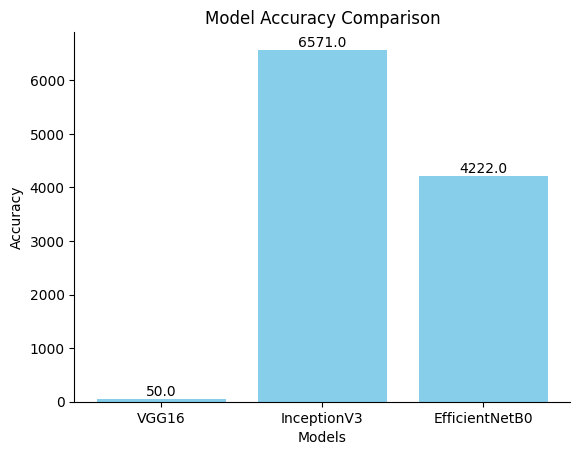

In [30]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
accuracy = [accuracy_vgg, accuracy_incep, accuracy_effnet]
accuracy = np.floor([i * 100 for i in accuracy])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

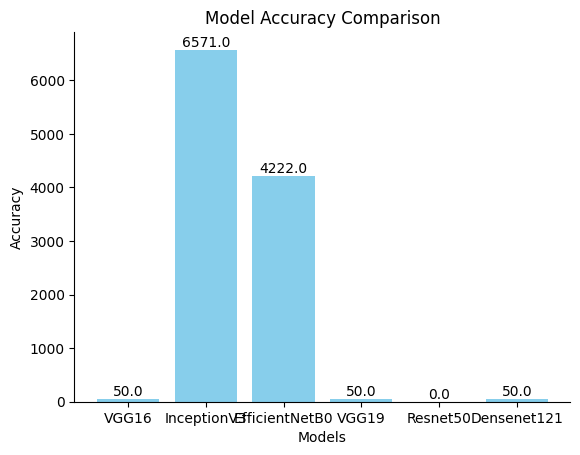

In [31]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0','VGG19','Resnet50','Densenet121']
accuracy = [accuracy_vgg, accuracy_incep, accuracy_effnet,accuracy_vgg19,accuracy_resnet,accuracy_densenet]
accuracy = np.floor([i * 100 for i in accuracy])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

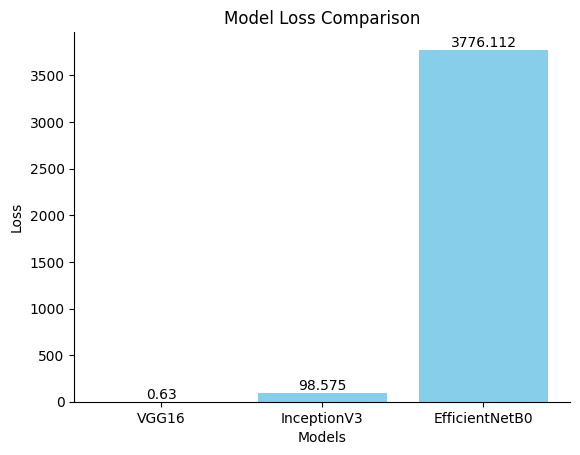

In [32]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
loss = [loss_vgg, loss_incep, loss_effnet]

fig, ax = plt.subplots()
bars = ax.bar(algos, loss, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

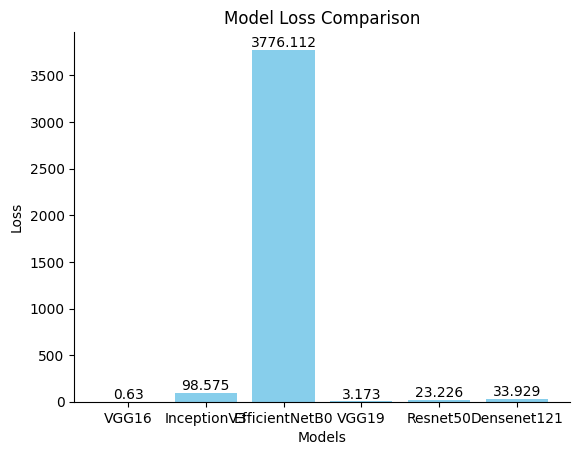

In [33]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0','VGG19','Resnet50','Densenet121']
loss = [loss_vgg, loss_incep, loss_effnet,loss_vgg19,loss_resnet,loss_densenet]

fig, ax = plt.subplots()
bars = ax.bar(algos, loss, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

# Deployment of EfficientB0

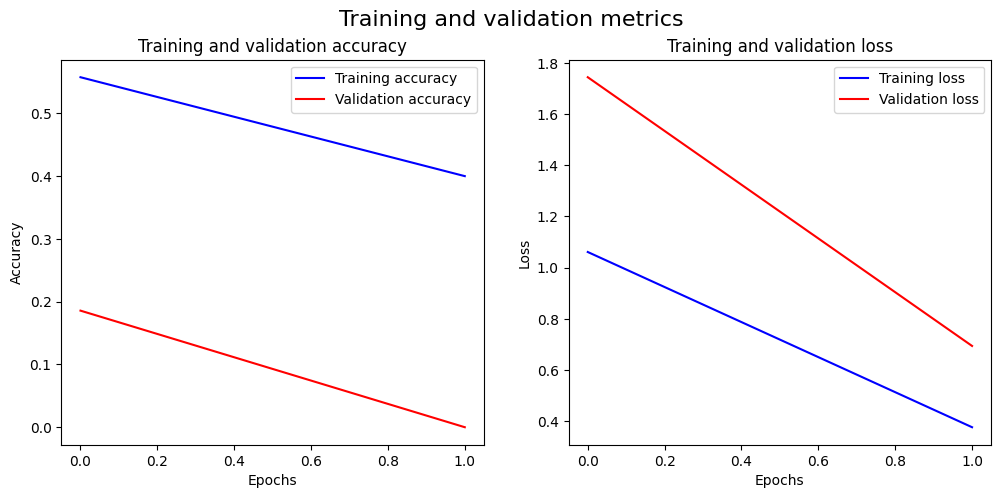

In [34]:
import urllib.request

wget= "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# URL of the file to download
# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

# # Destination file path
# destination = "helper_functions.py"

# # Download the file
# urllib.request.urlretrieve(url, destination)

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

accuracy = EffNetB0.history['accuracy']
val_accuracy = EffNetB0.history['val_accuracy']

loss = EffNetB0.history['loss']
val_loss = EffNetB0.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()





🔮Making predictions

# Making Prediction

<!-- Making Prediction -->

In [35]:
def chestScanPrediction(path, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])
        
        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Label: Normal
Actual Label: Large cell carcinoma


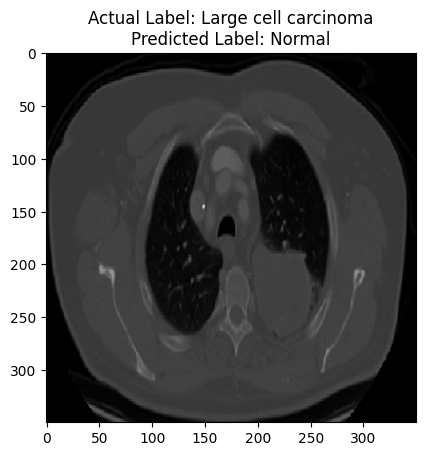

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Predicted Label: Normal
Actual Label: Adenocarcinoma


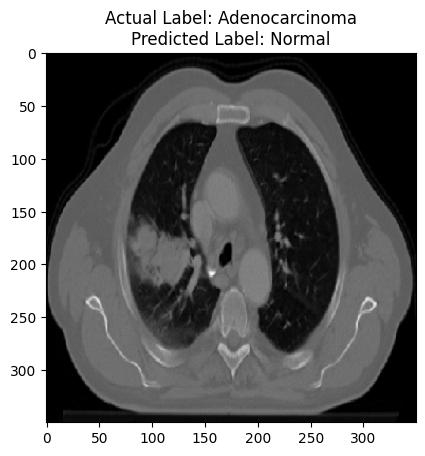

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted Label: Squamous cell carcinoma
Actual Label: Normal


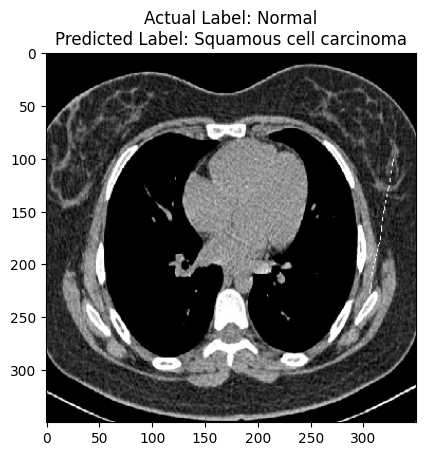

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted Label: Normal
Actual Label: Squamous cell carcinoma


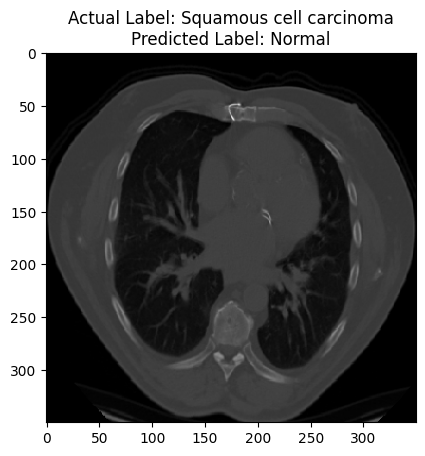

In [36]:


paths = [
    r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa\000003 (4).png",
    r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib\000009 (7).png",
    r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\train\normal\2 (2).png",
    r"C:\Users\smara\OneDrive\Desktop\Final Year Project\Data\train\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa\000004 (7).png"
]



actual_labels = [1, 0, 2, 3]

chestScanPrediction(paths, EffNetmodel, actual_labels)



In [37]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Deployment of VGG19

In [38]:
# import urllib.request

# wget= "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# # URL of the file to download
# # url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

# # # Destination file path
# # destination = "helper_functions.py"

# # # Download the file
# # urllib.request.urlretrieve(url, destination)

# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot
# vgg19_history = model.fit(train_images, train_labels, 
#                           epochs=10, 
#                           validation_data=(test_images, test_labels))
# accuracy = vgg19_history.history['accuracy']
# val_accuracy = vgg19_history.history['val_accuracy']
# vgg19_history = vgg19_history.history['loss']
# val_loss = vgg19_history.history['val_loss']
# epochs = range(len(accuracy))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
# ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
# ax1.set_title('Training and validation accuracy')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Accuracy')
# ax1.legend()

# ax2.plot(epochs, loss, 'b', label='Training loss')
# ax2.plot(epochs, val_loss, 'r', label='Validation loss')
# ax2.set_title('Training and validation loss')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Loss')
# ax2.legend()

# fig.suptitle('Training and validation metrics', fontsize=16)
# plt.show()

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.3631 - loss: 1.7410 - val_accuracy: 0.5585 - val_loss: 1.2828
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5931 - loss: 1.1654 - val_accuracy: 0.6489 - val_loss: 1.0372
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6507 - loss: 0.9960 - val_accuracy: 0.6505 - val_loss: 1.0076
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.6862 - loss: 0.9048 - val_accuracy: 0.6760 - val_loss: 0.9425
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7078 - loss: 0.8466 - val_accuracy: 0.6889 - val_loss: 0.9109
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7263 - loss: 0.7863 - val_accuracy: 0.6919 - val_loss: 0.9093
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7424 - loss: 0.7352 - val_accuracy: 0.6827 - val_loss: 0.9204
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7603 -

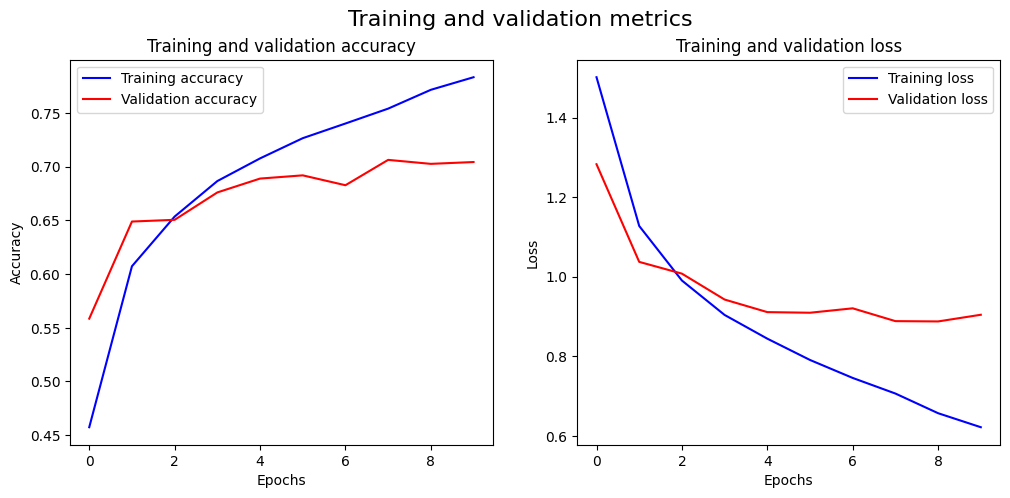

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
vgg19_history = model.fit(train_images, train_labels, 
                          epochs=10, 
                          validation_data=(test_images, test_labels))

# Extract metrics
accuracy = vgg19_history.history['accuracy']
val_accuracy = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']
epochs = range(len(accuracy))

# Plot the metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()


# VGG-19 is Best